### Calliope - POETRY LLM

[Calliope Repository](https://github.com/peppermintcoding/Calliope)

    Here rise to life again, dead poetry!
    Let it, O holy Muses, for I am yours,
    And here Calliope, strike a higher key,
    Accompanying my song with that sweet air
    which made the wretched Magpies feel a blow
    that turned all hope of pardon to despair
Dante, "Purgatorio", Canto I, lines 7 to 12

[Calliope Wikipedia](https://en.wikipedia.org/wiki/Calliope)

In [1]:
!git clone https://github.com/peppermintcoding/Calliope.git
!pip install -q -r "Calliope/requirements.txt"

Cloning into 'Calliope'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 7), reused 18 (delta 4), pack-reused 0
Receiving objects: 100% (25/25), 9.31 KiB | 1.55 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
import inspect
import math
import os
from tqdm import tqdm
from contextlib import nullcontext

import json
import pandas as pd
import numpy as np
import torch
from torch.nn import functional as F

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

### Tokenize from txt

In [3]:
# gutenberg_poem_dataset
full_text = ""
data = []
with open("/kaggle/input/gutenberg-poem/gutenberg-poetry-v001.ndjson", "r") as f:
    for line in f.readlines():
        data.append(json.loads(line.strip())["s"]+"\n")
full_text += "".join(data)
print(f"Gutenberg Dataset has {len(full_text.split()):,} words.")
with open("full_text.txt", "a") as f:
    f.write(full_text)

# kaggle_poem_dataset
full_text = ""
data = pd.read_csv("/kaggle/input/complete-poetryfoundationorg-dataset/kaggle_poem_dataset.csv", index_col=0)
full_text += "\n".join(data["Content"].to_list())
print(f"Kaggle Poem Dataset has {len(full_text.split()):,} words.")
with open("full_text.txt", "a") as f:
    f.write(full_text)

# rewritten kaggle_poem_dataset poems ( partly done )
full_text = ""
data = pd.read_csv("/kaggle/input/rewritten-poems/kaggle_poem_dataset_rewritten.csv", index_col="Index")
full_text += "\n".join(data["Rewritten Version"].to_list())
print(f"Rewritten Kaggle Poem Dataset has {len(full_text.split()):,} words.")
with open("full_text.txt", "a") as f:
    f.write(full_text)

# Button Poetry YouTube Transcripts
full_text = ""
data = pd.read_csv("/kaggle/input/button-poetry-transcripts/buttonpoetry_youtube_transribe.csv", index_col="Index")
# try to make it look like poetry from whisper transcript
data["Transcribed Text"] = data["Transcribed Text"].str.replace(". ", "\n", regex=False)
full_text += "\n".join(data["Transcribed Text"].to_list())
print(f"Button Poetry Dataset has {len(full_text.split()):,} words.")
with open("full_text.txt", "a") as f:
    f.write(full_text)

Gutenberg Dataset has 21,960,040 words.
Kaggle Poem Dataset has 4,029,850 words.
Rewritten Kaggle Poem Dataset has 292,842 words.
Button Poetry Dataset has 494,691 words.


In [4]:
from Calliope.data.tokenize import tokenize_txt

tokenize_txt("full_text.txt")
print(f"Number of training tokens: {len(np.memmap('train.bin', dtype=np.uint16, mode='r')):,}")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Number of training tokens: 40,919,287


In [5]:
# clean up memory on cpu
import gc

del data
del full_text
gc.collect()

0

### Training

In [6]:
# poor man's data loader
train_data = np.memmap('train.bin', dtype=np.uint16, mode='r')
def get_batch():
    ix = torch.randint(len(train_data) - model_args["block_size"], (batch_size,))
    x = torch.stack([torch.from_numpy((train_data[i:i+model_args["block_size"]]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((train_data[i+1:i+1+model_args["block_size"]]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [7]:
# tiny stories 33M https://huggingface.co/roneneldan/TinyStories-33M
# layers: 4
# heads: 16
# n_embd: 768
# block_size: 2048

# tiny stories 1M https://huggingface.co/roneneldan/TinyStories-1M
# layers: 8
# heads: 16
# n_embd: 64
# block_size: 2048

model_args = {
    "n_layer": 12,
    "n_head": 24,
    "n_embd": 768,
    "dropout": 0.1,
    "bias": False,
    "block_size": 1024,
}

out_dir = 'out-poetry'
checkpoint_interval = 500 # save checkpoint every n steps
log_interval = 10 # don't print too too often

gradient_accumulation_steps = 1
batch_size = 8

epochs = 2
max_iters = int(train_data.shape[0] / (gradient_accumulation_steps * batch_size * model_args["block_size"]) * epochs)
print(f"Max Iterations: {max_iters}")

learning_rate = 1e-4
decay_lr = True # whether to decay the learning rate
lr_decay_iters = 10_000 # should be ~= max_iters per Chinchilla
min_lr = 1e-5 # should be ~= learning_rate/10 per Chinchilla
beta1 = 0.9
beta2 = 0.99 # make a bit bigger because number of tokens per iter is small
warmup_iters = 1000 # how many steps to warm up for

# adamw optimizer
weight_decay = 1e-1
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0

# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
print(f"training in dytpe: {dtype}")
compile = False # use PyTorch 2.0 to compile the model to be faster

Max Iterations: 9990
training in dytpe: float16


In [8]:
from Calliope.model import GPTConfig, GPT

seed_offset = 0
tokens_per_iter = gradient_accumulation_steps * batch_size * model_args["block_size"]
print(f"tokens per iteration will be: {tokens_per_iter:,}")

os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(69 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)

if compile:
    print("compiling the model... (takes a ~minute)")
    model = torch.compile(model)

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

tokens per iteration will be: 8,192
number of parameters: 95.27M
num decayed parameter tensors: 34, with 96,043,008 parameters
num non-decayed parameter tensors: 17, with 13,056 parameters
using fused AdamW: True


In [9]:
X, Y = get_batch()
train_loss_history = []

pbar = tqdm(range(max_iters+1))
for iter_num in pbar:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # write checkpoints
    if iter_num % checkpoint_interval == 0 or iter_num == max_iters:
        if iter_num > 0:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'model_args': model_args,
                'iter_num': iter_num,
            }
            torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch()
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)

    if iter_num % log_interval == 0:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        train_loss_history.append([iter_num, lossf])
        pbar.set_description(f"step {iter_num}: loss {lossf:.4f}")
    if np.isnan(lossf):
        print(f"Loss nan at {iter_num} iter steps.")
        break

step 6200: loss nan:  62%|██████▏   | 6200/9991 [45:20<27:43,  2.28it/s]     

Loss nan at 6200 iter steps.


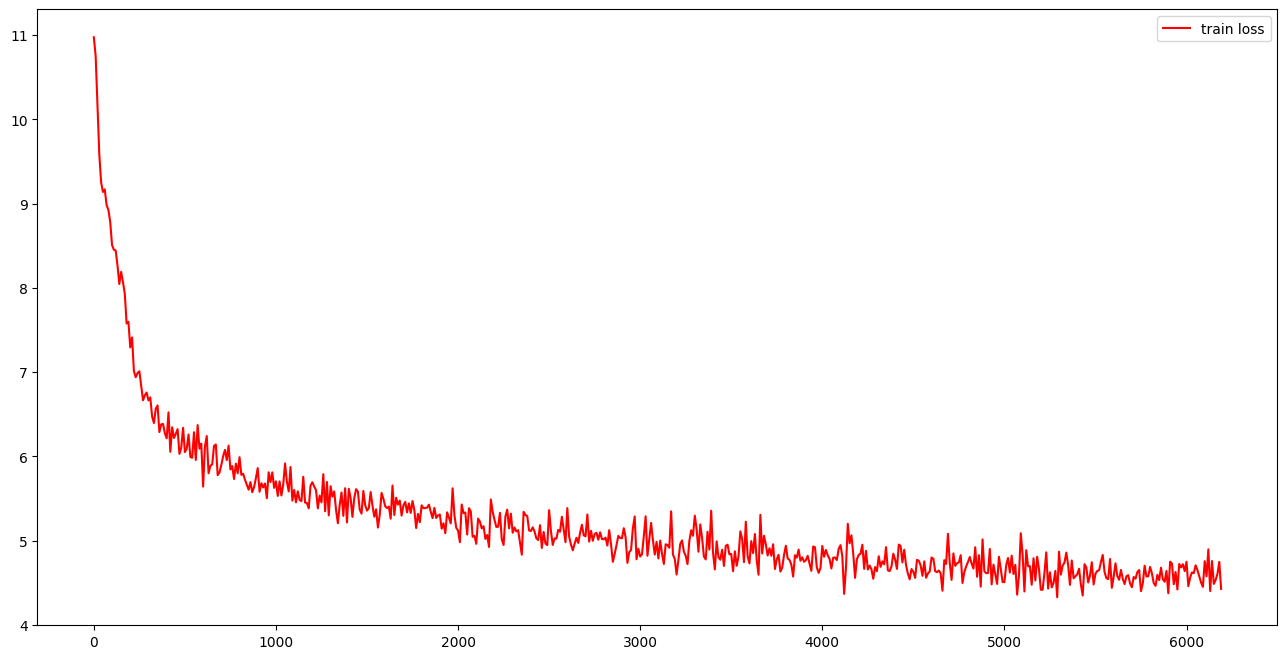

In [10]:
plt.plot([x[0] for x in train_loss_history], [x[1] for x in train_loss_history], c="r", label="train loss")
plt.legend()
plt.show()

### Load Model from memory

In [11]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
model.load_state_dict(torch.load("out-poetry/ckpt.pt")["model"])
model.to(device)
model.eval()

number of parameters: 95.27M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=False)
          (c_proj): Linear(in_features=768, out_features=768, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [12]:
prompt = "Stars aligned "
idx = model.generate(torch.tensor([tokenizer(prompt)["input_ids"]], device=device), 75, temperature=0.9)
words = tokenizer.decode(idx[0])
print(words)

Stars aligned  Above
Our notes and sprigals
Of loss and love and arts, even on earth,
The welcome-vail, and the heart of earth,
The soul for man you may find
Have eager till to see.
Now at the shadow of the sky
It rises in the air; and there
The lark and the voices of the breath
